### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgbm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import lightgbm as lgbm

### Read files & submission file for template

In [2]:
X_train = pd.read_csv('X_train.csv',index_col='ROW_ID')
X_test = pd.read_csv('X_test.csv',index_col='ROW_ID')

y_train = pd.read_csv('y_train.csv',index_col='ROW_ID')
sample_submission = pd.read_csv('sample_submission.csv',index_col='ROW_ID')

In [3]:
X_train.columns

Index(['TS', 'ALLOCATION', 'RET_20', 'RET_19', 'RET_18', 'RET_17', 'RET_16',
       'RET_15', 'RET_14', 'RET_13', 'RET_12', 'RET_11', 'RET_10', 'RET_9',
       'RET_8', 'RET_7', 'RET_6', 'RET_5', 'RET_4', 'RET_3', 'RET_2', 'RET_1',
       'SIGNED_VOLUME_20', 'SIGNED_VOLUME_19', 'SIGNED_VOLUME_18',
       'SIGNED_VOLUME_17', 'SIGNED_VOLUME_16', 'SIGNED_VOLUME_15',
       'SIGNED_VOLUME_14', 'SIGNED_VOLUME_13', 'SIGNED_VOLUME_12',
       'SIGNED_VOLUME_11', 'SIGNED_VOLUME_10', 'SIGNED_VOLUME_9',
       'SIGNED_VOLUME_8', 'SIGNED_VOLUME_7', 'SIGNED_VOLUME_6',
       'SIGNED_VOLUME_5', 'SIGNED_VOLUME_4', 'SIGNED_VOLUME_3',
       'SIGNED_VOLUME_2', 'SIGNED_VOLUME_1', 'AVG_DAILY_TURNOVER'],
      dtype='object')

### Features

In [4]:
RET_features = [f'RET_{i}' for i in range(1,20)]
SIGNED_VOLUME_features = [f'SIGNED_VOLUME_{i}' for i in range(1,20)]
TURNOVER_features = ['AVG_DAILY_TURNOVER']

In [5]:
for i in [3,5,10,15,20]:
    X_train[ f'AVERAGE_PERF_{i}'] = X_train[RET_features[:i]].mean(1)
    X_train[ f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_train.groupby('TS')[ f'AVERAGE_PERF_{i}'].transform('mean')
    
    X_test[ f'AVERAGE_PERF_{i}'] = X_test[RET_features[:i]].mean(1)
    X_test[ f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_test.groupby('TS')[ f'AVERAGE_PERF_{i}'].transform('mean')

In [6]:
features = RET_features + SIGNED_VOLUME_features + TURNOVER_features
features = features + [ f'AVERAGE_PERF_{i}' for i in [3,5,10,15,20]]
features = features + [ f'ALLOCATIONS_AVERAGE_PERF_{i}' for i in [3,5,10,15,20]]

### Fitting one simple Ridge

In [7]:
new_ridge = linear_model.Ridge(alpha=1e-2, fit_intercept=False)

new_ridge.fit(X_train[features].to_numpy(na_value=0),y_train.to_numpy(na_value=0))

preds_ridge = pd.DataFrame(new_ridge.predict(X_test[features].fillna(0).to_numpy(na_value=0)), index = sample_submission.index,columns=['target'])

In [8]:
(preds_ridge>0).astype(int).to_csv('preds_ridge.csv')

### Fitting a random forest using cross validation

In [9]:

rf_params = {
    'n_estimators': 100,
    'max_depth': 2**5,
    'random_state': 42,
    'n_jobs': 40,
}

train_dates = X_train['TS'].unique()
test_dates = X_test['TS'].unique()

n_splits = 5
scores = []
models = []
 
splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = X_train['TS'].isin(local_train_dates)
    local_test_ids = X_train['TS'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids,features]
    y_local_train = y_train.loc[local_train_ids,'target']
    X_local_test = X_train.loc[local_test_ids,features]
    y_local_test = y_train.loc[local_test_ids,'target']

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestRegressor(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict(X_local_test)
    
    models.append(model)
    score = accuracy_score((y_local_test>0).astype(int),
                (y_local_pred>0).astype(int))
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.40%
Fold 2 - Accuracy: 51.60%
Fold 3 - Accuracy: 51.39%
Fold 4 - Accuracy: 51.89%
Fold 5 - Accuracy: 51.64%
Accuracy: 51.58% [51.40 ; 51.77] (+- 0.19)


<Axes: >

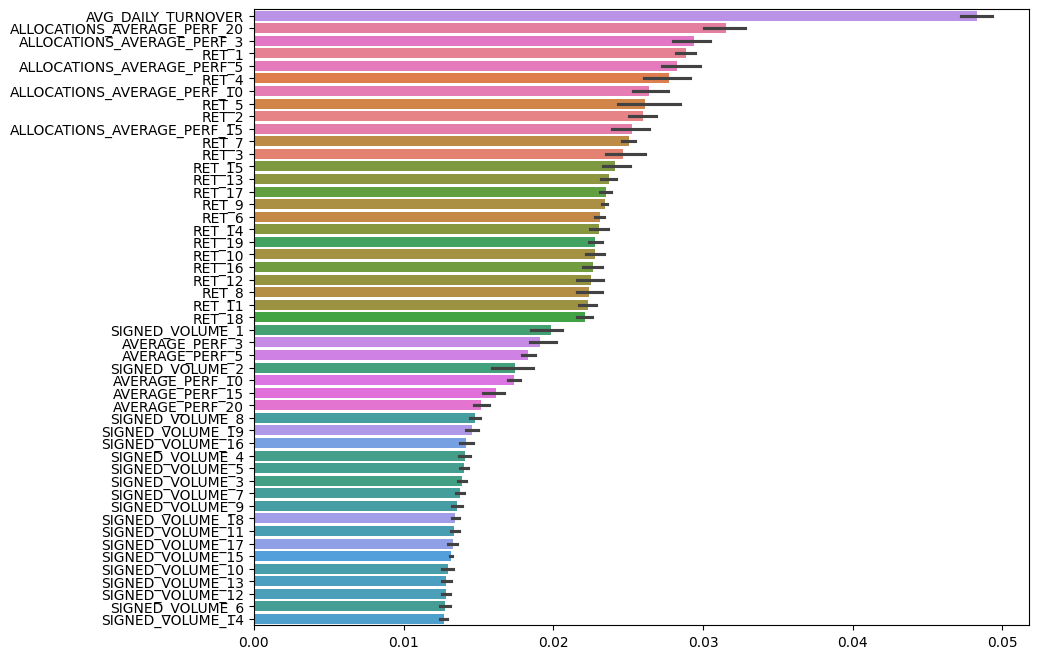

In [10]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

plt.figure(figsize=(10, 8))

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)


In [11]:
rf_params['random_state'] = 0
model = RandomForestRegressor(**rf_params)
model.fit(X_train[features].fillna(0), y_train['target'])
preds_rf = model.predict(X_test[features].fillna(0))
preds_rf = pd.DataFrame(preds_rf, index=sample_submission.index,columns=['target'])

In [12]:
(preds_rf>0).astype(int).to_csv('preds_rf.csv')

### Fitting a lightgbm using cross validation

In [13]:

# A quite large number of trees with low depth to prevent overfits
lgbm_params = {
                "metric": "mse",
                "num_threads": 50,
                "seed": 42,
                "verbosity": -1,
                'learning_rate': 1e-3,
                'max_depth': 5,
}
NUM_BOOST_ROUND = 100

train_dates = X_train['TS'].unique()
test_dates = X_test['TS'].unique()

n_splits = 10
scores_lgbm = []
models_lgbm = []
 
splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True,).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = X_train['TS'].isin(local_train_dates)
    local_test_ids = X_train['TS'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids,features]
    y_local_train = y_train.loc[local_train_ids,'target']
    X_local_test = X_train.loc[local_test_ids,features]
    y_local_test = y_train.loc[local_test_ids,'target']

    X_local_train = X_local_train
    X_local_test = X_local_test

    train_data = lgbm.Dataset(X_local_train, label=y_local_train.values) 
    
    model_lgbm = lgbm.train(lgbm_params, train_data,num_boost_round=NUM_BOOST_ROUND) 
    
    y_local_pred = model_lgbm.predict(X_local_test.values, num_threads = lgbm_params['num_threads'])
    
    
    models_lgbm.append(model_lgbm)
    score = accuracy_score((y_local_test>0).astype(int),
                (y_local_pred>0).astype(int))
    scores_lgbm.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores_lgbm)*100
std = np.std(scores_lgbm)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 49.39%
Fold 2 - Accuracy: 51.01%
Fold 3 - Accuracy: 51.37%
Fold 4 - Accuracy: 50.24%
Fold 5 - Accuracy: 49.49%
Fold 6 - Accuracy: 50.16%
Fold 7 - Accuracy: 49.76%
Fold 8 - Accuracy: 50.39%
Fold 9 - Accuracy: 51.49%
Fold 10 - Accuracy: 50.25%
Accuracy: 50.36% [49.66 ; 51.05] (+- 0.70)


<Axes: >

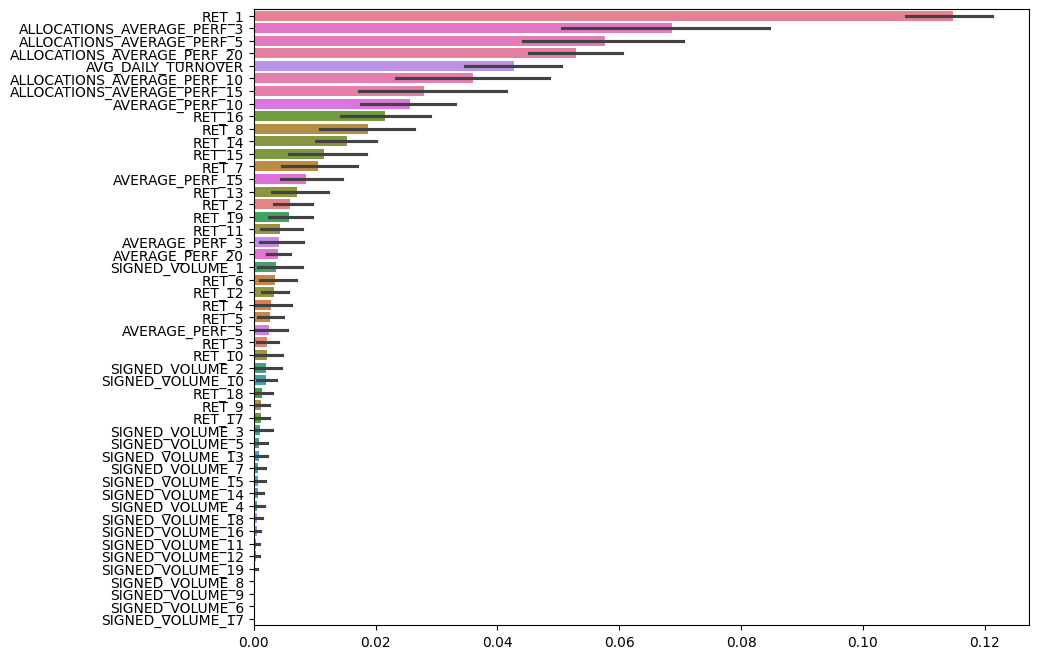

In [14]:
feature_importances = pd.DataFrame([model_lgbm.feature_importance(importance_type='gain') for model_lgbm in models_lgbm], columns=features)

plt.figure(figsize=(10, 8))

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)


In [15]:
train_data = lgbm.Dataset(X_train[features], label=y_train) 
model_lgbm = lgbm.train(lgbm_params, train_data,num_boost_round=NUM_BOOST_ROUND) 
preds_lgbm = model_lgbm.predict(X_test[features])
preds_lgbm = pd.DataFrame(preds_lgbm, index=sample_submission.index,columns=['target'])

In [16]:
(preds_lgbm>0).astype(int).to_csv('preds_lgbm.csv')